In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
SRC_DIR = os.path.join(os.path.dirname(os.getcwd()), 'src')
sys.path.append(os.path.normpath(SRC_DIR))

import platform
import operator
import itertools
import datetime as dt

import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.offsetbox import AnchoredText
from IPython.display import display

from pipeline import JHU, CTP, NYT
from utils import ISO_3166_2

seaborn.set(palette='pastel')
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 100

print("python", platform.python_version())
print("pandas", pd.__version__)

python 3.8.2
pandas 1.0.3


## data sources

In [3]:
kwargs = dict(verbose=False)
CATALOG = {
    'jhu': JHU(**kwargs).clean,
    'ctp': CTP(**kwargs).clean,
    'nyt': NYT(**kwargs).clean,
}

for name, df in CATALOG.items():
    display(f'preview: {name}', df.tail(3))

'preview: jhu'

,filedate,day,country,state,county,confirmed,deaths,recovered,last_update,_province_state
27596,2020-03-27,2020-03-27,West Bank and Gaza,West Bank and Gaza,West Bank and Gaza,91.0,1.0,17.0,2020-03-27 23:23:03,[None]
27597,2020-03-27,2020-03-27,Zambia,Zambia,Zambia,22.0,0.0,0.0,2020-03-27 23:23:03,[None]
27598,2020-03-27,2020-03-27,Zimbabwe,Zimbabwe,Zimbabwe,5.0,1.0,0.0,2020-03-27 23:23:03,[None]


'preview: ctp'

,date,state,positive,negative,pending,hospitalized,death,total,hash,date_checked,total_test_results,fips,death_increase,hospitalized_increase,negative_increase,positive_increase,total_test_results_increase
1258,20200328,West Virginia,96.0,2331.0,6.0,1.0,0.0,2433,1a356d8df9f5461221287aae15a7ecf95e273aeb,2020-03-28 20:00:00+00:00,2427,54,0.0,0.0,552.0,20.0,572.0
1259,20200328,Wisconsin,989.0,15232.0,NaN,NaN,13.0,16221,64137a9be9ebca4d2f0585cca9319064a1785a04,2020-03-28 20:00:00+00:00,16221,55,0.0,0.0,2092.0,147.0,2239.0
1260,20200328,Wyoming,82.0,1475.0,NaN,14.0,0.0,1557,44a009ad19612b01340eeb3374d72c76d4db0168,2020-03-28 20:00:00+00:00,1557,56,0.0,3.0,264.0,12.0,276.0


'preview: nyt'

,date,county,state,fips,cases,deaths
15833,2020-03-27,Sweetwater,Wyoming,56037,1,0
15834,2020-03-27,Teton,Wyoming,56039,12,0
15835,2020-03-27,Washakie,Wyoming,56043,1,0


## ontology

In [4]:
METRICS = ['cases', 'deaths', 'recovered']
LIMITS = dict(zip(METRICS, [100, 10, 10]))
LEVELS = ['country', 'state', 'county']


def rollup(df, level):
    df = df.copy()
    if level == 'county':
        return df

    agg_level = ['date', 'day', 'country']

    if level == 'state':
        gdf = df.groupby([*agg_level, 'state'])
    else:
        gdf = df.groupby(agg_level)

    return (
        gdf
        .agg({**dict(zip(METRICS, [sum, sum, sum])),
              'source': set})
        .assign(source=lambda df: df['source'].map(lambda x: ','.join(x)))
        .reset_index()
    )


def levels_in_df(df):
    return [l for l in LEVELS if l in df.columns]


### combined

In [5]:
COLS = [
    'date',
    'day',
    *LEVELS,
    *METRICS,
    'source',
]

nyt_dates = CATALOG['nyt']['date'].drop_duplicates().values

df = pd.concat([
    # baseline metrics from JHU except for US data existing in NYT
    CATALOG['jhu'].copy()
    .loc[lambda df: (df['country'] != 'US') | ~df['filedate'].isin(nyt_dates)]
    .rename(columns={
        'filedate': 'date',
        'confirmed': 'cases',
    })
    .drop([
        '_province_state',
        'last_update',
    ], axis=1)
    .assign(source='jhu')
    [COLS],

    # US metrics from NYT
    CATALOG['nyt'].copy()
    .assign(
        day=lambda df: df['date'].dt.strftime("%Y-%m-%d"),
        country='US',
        recovered=np.nan,
        source='nyt'
    )
    [COLS]
])


df = (
    df
    .assign(cases=lambda df: df['cases'].fillna(0))
    .loc[lambda df: df['cases'] > 0]  # only non-zero cases interesting
    .sort_values(['date', *LEVELS])
    .reset_index(drop=True)
)

CATALOG['df.combined'] = df
display('sources', df['source'].value_counts())
display('preview', df.tail())

'sources'

nyt    15836
jhu     7344
Name: source, dtype: int64

'preview'

,date,day,country,state,county,cases,deaths,recovered,source
23175,2020-03-27,2020-03-27,Venezuela,Venezuela,Venezuela,107.0,1.0,31.0,jhu
23176,2020-03-27,2020-03-27,Vietnam,Vietnam,Vietnam,163.0,0.0,20.0,jhu
23177,2020-03-27,2020-03-27,West Bank and Gaza,West Bank and Gaza,West Bank and Gaza,91.0,1.0,17.0,jhu
23178,2020-03-27,2020-03-27,Zambia,Zambia,Zambia,22.0,0.0,0.0,jhu
23179,2020-03-27,2020-03-27,Zimbabwe,Zimbabwe,Zimbabwe,5.0,1.0,0.0,jhu


### derived

In [6]:
def with_cases_active(df):
    df['cases_active'] = (
        df['cases'].fillna(0)
        - df['deaths'].fillna(0)
        - df['recovered'].fillna(0)
    )
    return df


def with_cfr(df):
    df['cfr'] = 100 * (df['deaths'].fillna(0) / df['cases'])
    return df


def with_diffs(df):
    agg_level = levels_in_df(df)
    df[[f"{m}_new" for m in METRICS]] = (
        df
        .sort_values('date')
        .groupby(agg_level)[METRICS]
        .diff()
    )
    return df


def with_pct_change(df):
    agg_level = levels_in_df(df)
    df[[f"{m}_pct_change" for m in METRICS]] = 100 * (
        df
        .sort_values('date')
        .groupby(agg_level)[METRICS]
        .pct_change()
    )
    return df

In [7]:
for i, level in enumerate(LEVELS):
    df = (
        rollup(CATALOG['df.combined'], level)
        .pipe(with_cases_active)
        .pipe(with_cfr)
        .pipe(with_diffs)
        .pipe(with_pct_change)
    )
    CATALOG[f'df.derived.{level}'] = df

df = CATALOG['df.derived.county']
df = df.loc[df['state'] == 'California']
display('preview', df.tail())

'preview'

,date,day,country,state,county,cases,deaths,recovered,source,cases_active,cfr,cases_new,deaths_new,recovered_new,cases_pct_change,deaths_pct_change,recovered_pct_change
21539,2020-03-27,2020-03-27,US,California,Tulare,24.0,0.0,NaN,nyt,24.0,0.000000,4.0,0.0,NaN,20.000000,NaN,NaN
21540,2020-03-27,2020-03-27,US,California,Unknown,1.0,0.0,NaN,nyt,1.0,0.000000,0.0,0.0,NaN,0.000000,NaN,NaN
21541,2020-03-27,2020-03-27,US,California,Ventura,83.0,3.0,NaN,nyt,80.0,3.614458,22.0,2.0,NaN,36.065574,200.0,NaN
21542,2020-03-27,2020-03-27,US,California,Yolo,16.0,1.0,NaN,nyt,15.0,6.250000,5.0,0.0,NaN,45.454545,0.0,NaN
21543,2020-03-27,2020-03-27,US,California,Yuba,3.0,0.0,NaN,nyt,3.0,0.000000,0.0,0.0,NaN,0.000000,NaN,NaN


### offset

In [8]:
def with_offset(df, metric, limit=100):
    col = f"{metric}_offset"
    agg_level = levels_in_df(df)
    df[col] = (
        df
        .copy()
        .loc[df[metric] >= limit]
        .sort_values([*agg_level, 'date', 'day'])
        .groupby(agg_level)[metric]
        .cumcount()
    )
    return df


def reindex_offset(df, offset):
    agg_level = levels_in_df(df)
    df = (
        df
        .copy()
        .dropna(subset=[offset])
        .set_index([offset, 'offset_metric', *agg_level])
        .reset_index()
    )
    return df


In [9]:
for i, level in enumerate(LEVELS):
    df = CATALOG[f'df.derived.{level}'].copy()
    id_vals = df.columns.values
    df = (
        df
        .pipe(with_offset, 'cases', LIMITS['cases'])
        .pipe(with_offset, 'deaths', LIMITS['deaths'])
        .pipe(with_offset, 'recovered', LIMITS['recovered'])
        .melt(
            id_vals,
            [f'{m}_offset' for m in METRICS],
            'offset_metric',
            'offset'
        )
        .replace(r"_offset$", '', regex=True)
        .pipe(reindex_offset, 'offset')
    )
    CATALOG[f'df.offset.{level}'] = df

df = CATALOG['df.offset.state']
df = df.loc[(df['state'] == 'California')
            & (df['offset_metric'] == 'cases')]
display('preview', df.tail())

'preview'

,offset,offset_metric,country,state,date,day,cases,deaths,recovered,source,cases_active,cfr,cases_new,deaths_new,recovered_new,cases_pct_change,deaths_pct_change,recovered_pct_change
2370,16.0,cases,US,California,2020-03-23,2020-03-23,2240.0,39.0,0.0,nyt,2201.0,1.741071,389.0,4.0,0.0,21.015667,11.428571,NaN
2525,17.0,cases,US,California,2020-03-24,2020-03-24,2646.0,52.0,0.0,nyt,2594.0,1.965231,406.0,13.0,0.0,18.125000,33.333333,NaN
2687,18.0,cases,US,California,2020-03-25,2020-03-25,3185.0,68.0,0.0,nyt,3117.0,2.135008,539.0,16.0,0.0,20.370370,30.769231,NaN
2856,19.0,cases,US,California,2020-03-26,2020-03-26,4062.0,83.0,0.0,nyt,3979.0,2.043328,877.0,15.0,0.0,27.535322,22.058824,NaN
3030,20.0,cases,US,California,2020-03-27,2020-03-27,4917.0,104.0,0.0,nyt,4813.0,2.115111,855.0,21.0,0.0,21.048744,25.301205,NaN


## visualization

### overview

In [10]:
# filter to latest date and significant impact
df = CATALOG['df.derived.state'].copy()
levels = levels_in_df(df)
df = (
    df
    .sort_values([*levels, 'date'])
    .groupby(levels)
    .last()
    .reset_index()
    .query(f'cases >= {LIMITS["cases"]}')
)

def prettify(df):
    for m in [*METRICS, 'cases_active', *[f'{m}_new' for m in METRICS]]:
        df[m] = df[m].map(lambda x: f"{x:,.0f}")
    for m in ['cfr', *[f'{m}_pct_change' for m in METRICS]]:
        df[m] = df[m].map(lambda x: f"{x:,.1f}")
    if 'state' in df.columns:
        df.loc[df['country'] == df['state'], 'state'] = ''
    if 'county' in df.columns:
        df.loc[df['country'] == df['county'], 'county'] = ''
    return df.drop(['day'], axis=1)

display(
    "totals",
    df[METRICS]
    .sum()
    .rename('total')
    .map(lambda x: f"{x:,.0f}")
    .to_frame()
)

idx = ['date', 'source', *levels, *METRICS]
display(
    "regions with most cases",
    prettify(df.sort_values('cases', ascending=False))
    [idx]
    .reset_index(drop=True)
    .head(10)
)
display(
    "regions fastest growing, regions with 500 or more new cases/day",
    prettify(df.query('cases_new > 500')
               .sort_values('cases_pct_change', ascending=False))
    [[*idx, 'cases_new', 'cases_pct_change']]
    .reset_index(drop=True)
    .head(15)
)

'totals'

,total
cases,"592,152"
deaths,"27,230"
recovered,"129,960"


'regions with most cases'

,date,source,country,state,cases,deaths,recovered
0,2020-03-27,jhu,Italy,,"86,498","9,134","10,950"
1,2020-03-27,jhu,China,Hubei,"67,801","3,174","61,732"
2,2020-03-27,jhu,Spain,,"65,719","5,138","9,357"
3,2020-03-27,jhu,Germany,,"50,871",342,"6,658"
4,2020-03-27,nyt,US,New York,"44,636",535,0
5,2020-03-27,jhu,France,,"32,964","1,995","5,700"
6,2020-03-27,jhu,Iran,,"32,332","2,378","11,133"
7,2020-03-27,jhu,UK,,"14,543",759,135
8,2020-03-27,jhu,Switzerland,,"12,928",231,"1,530"
9,2020-03-27,jhu,South Korea,,"9,332",139,"4,528"


'regions fastest growing, regions with 500 or more new cases/day'

,date,source,country,state,cases,deaths,recovered,cases_new,cases_pct_change
0,2020-03-27,jhu,Turkey,,"5,698",92,42,"2,069",57.0
1,2020-03-27,nyt,US,Georgia,"2,211",64,0,562,34.1
2,2020-03-27,nyt,US,Massachusetts,"3,240",35,0,823,34.1
3,2020-03-27,nyt,US,Pennsylvania,"2,218",23,0,528,31.2
4,2020-03-27,nyt,US,Florida,"3,199",46,0,720,29.0
5,2020-03-27,nyt,US,New Jersey,"8,825",115,0,"1,949",28.3
6,2020-03-27,nyt,US,Michigan,"3,652",93,0,774,26.9
7,2020-03-27,jhu,UK,,"14,543",759,135,"2,885",24.7
8,2020-03-27,nyt,US,California,"4,917",104,0,855,21.0
9,2020-03-27,jhu,Portugal,,"4,268",76,43,724,20.4


## timeseries

In [11]:
SOURCES = ['Johns Hopkins University', 'The New York Times']

def infotext():
    return f"updated: {dt.datetime.now().strftime('%Y-%m-%d %H:%M')}\n" \
           f"sources: {', '.join(SOURCES)}"


def configure_yaxis(ax):
    
    def formatter(number, pos=None):
        """Convert a number into a human readable format."""
        magnitude = 0
        while abs(number) >= 1000:
            magnitude += 1
            number /= 1000.0
        decimals = 1 if number < 1 else 0
        return f"{number:,.{decimals}f}{['', 'k', 'M', 'B'][magnitude]}"

    ax.yaxis.set_major_formatter(ticker.FuncFormatter(formatter))
    
    # human readable y scale ticks
    ymin, ymax = ax.get_ylim()
    ticks = map(lambda x: (x, 2 * x, 5 * x), ax.get_yticks())
    ticks = itertools.chain(*ticks)
    ticks = list(filter(lambda y: (y > ymin) & (y < ymax), ticks))[1:]
    if len(ticks) > 10:
        ticks = ticks[2:]
    ax.set_yticks(ticks)


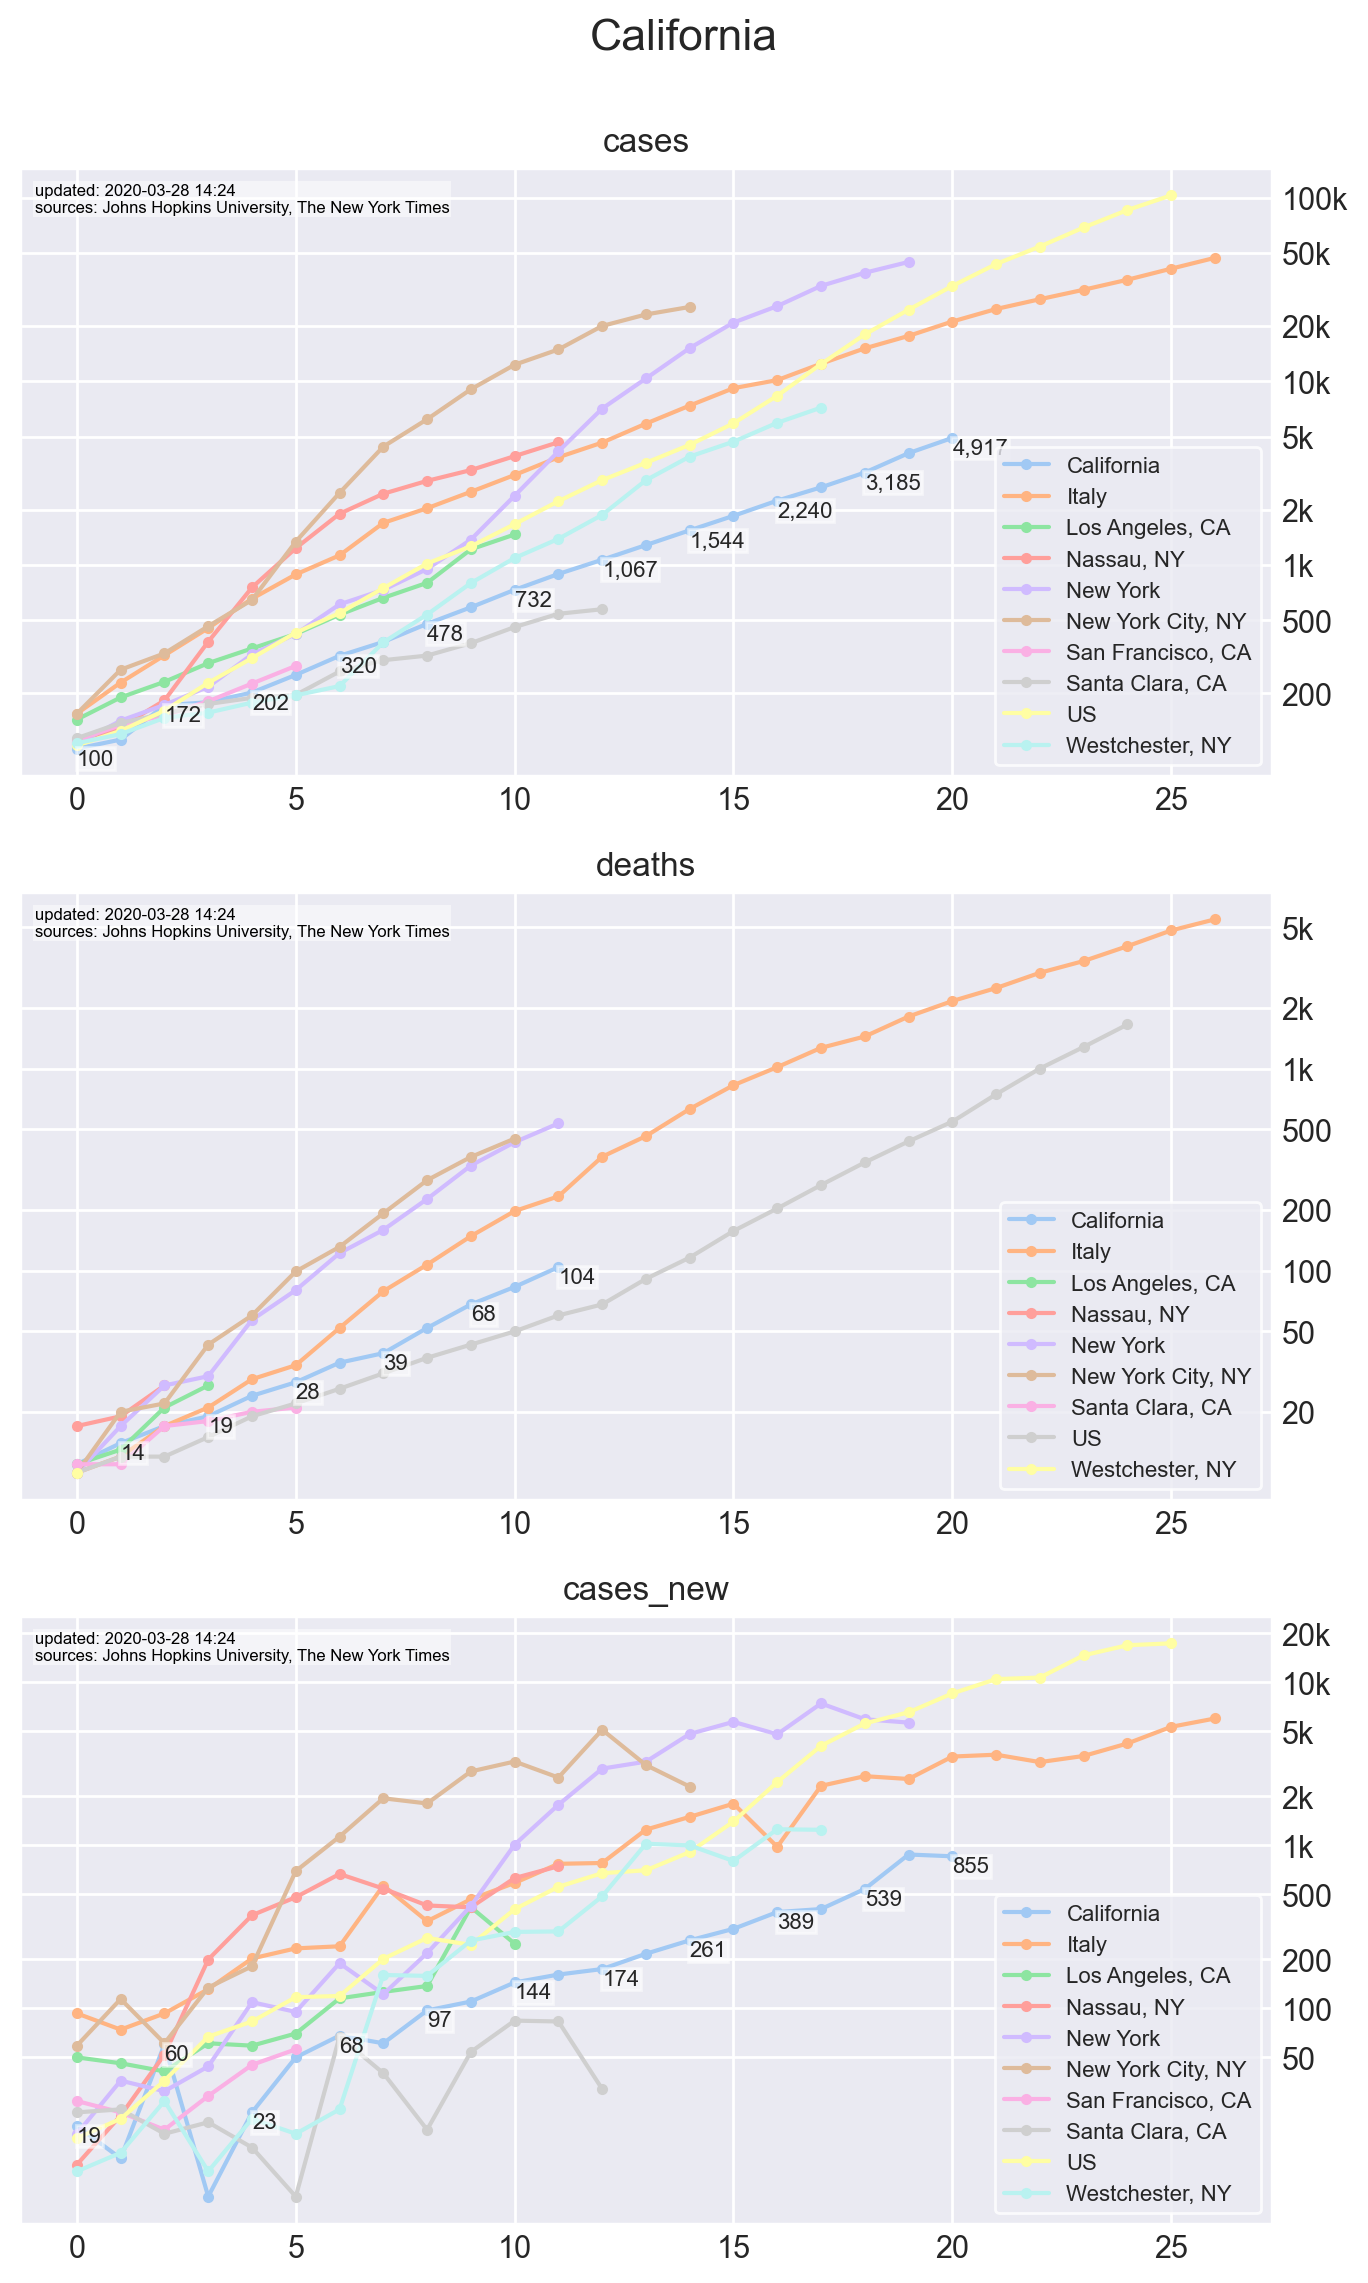

In [12]:
def get_timeseries(series, metric, offset_metric):
    dfs = {}
    for level, config in series.items():
        df = config['df'].copy()

        # county names may clash with state names so deconflict
        if level == 'county':
            df['_state'] = df['state'].replace(ISO_3166_2)
            df['county'] = df[['county', '_state']].agg(', '.join, axis=1)
            df = df.drop(['_state'], axis=1)

        filter_level = config.get('series_level', level)
        df = (
            df
            .loc[lambda df: df['offset_metric'] == offset_metric]
            .loc[lambda df: df[filter_level].isin(config['series'])]
        )
        
        if 'state' not in df.columns:
            df['state'] = df['country']
        if 'county' not in df.columns:
            df['county'] = df['state']
        dfs[level] = df

    df = pd.concat(dfs)
    # coalesce(county, state, country)
    df['region'] = df['county'].fillna(df['state']).fillna(df['country'])
    df = df.pivot(index='offset', columns='region', values=metric)
    return df


def plot(series, plots, highlight='Italy', dpi=100):
    
    days = 26
    from_date = (dt.datetime.now() - dt.timedelta(days=days)).strftime("%Y-%m-%d")
    
    rows = len(plots)
    fig, axs = plt.subplots(rows, 1, figsize=(7, rows * 4), dpi=dpi, facecolor='white')
    
    for i, t in enumerate(plots.items()):
        metric, offset_metric = t
        ax = axs[i] if rows > 1 else axs

        ts = get_timeseries(series, metric, offset_metric)[:days]
        ts.plot(title=metric, marker='.', ax=ax)
        
        # y-axis
        ax.set_yscale('log', basey=10)
        configure_yaxis(ax)
        ax.yaxis.tick_right()
        ax.tick_params(axis='both', which='both',length=0)

        # x-axis
        ax.xaxis.label.set_visible(False)
        ax.set_xticks(range(0, days, 5))
        
        # data labels
        values = ts[highlight].dropna().values
        for i, v in enumerate(values):
            # plot when i has same parity as number of elements
            # e.g. for 20 values, want to plot odd numbered values
            # to ensure i=19 (last element) is annotated
            if ((len(values) % 2) == ((i + 1) % 2)) & (v > 0):
                frmt = f'{v:,.1f}' if series in ['cfr'] else f'{v:,.0f}'
                bbox = dict(pad=0.5, facecolor='white', alpha=0.5)
                ax.text(i, v, frmt, ha='left', va='top', fontsize=8, bbox=bbox)

        # info text box
        props = dict(color='black', fontsize=6)
        box = AnchoredText(infotext(), loc=2, frameon=True, pad=0.1,
                           borderpad=0.8, prop=props)
        plt.setp(box.patch, facecolor='white', alpha=0.5, linewidth=0)
        ax.add_artist(box)
        
        # legend
        plt.sca(ax)
        leg = plt.legend(loc=4, prop={'size':8})
        leg.get_frame().set_edgecolor('white')
        leg.get_frame().set_linewidth(1.0)

    if rows > 1:
        fig.suptitle(highlight, fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])


plot(
    series={
        'country': {
            'df': CATALOG['df.offset.country'],
            'series': ['US', 'Italy'],
        },
        'state': {
            'df': CATALOG['df.offset.state'],
            'series': ['New York', 'California'],
        },
        'county': {
            'df': CATALOG['df.offset.county'],
            'series': [
                'New York City, NY', 'Westchester, NY', 'Nassau, NY',
                'Los Angeles, CA', 'Santa Clara, CA', 'San Francisco, CA',
            ],
#             'series': ['California'],
#             'series_level': 'state',
        }
    },
    plots={  # k = metric to plot; v = offset_metric index to use
        'cases': 'cases',
        'deaths': 'deaths',
        'cases_new': 'cases',
    },
    **dict(highlight='California', dpi=200),
)

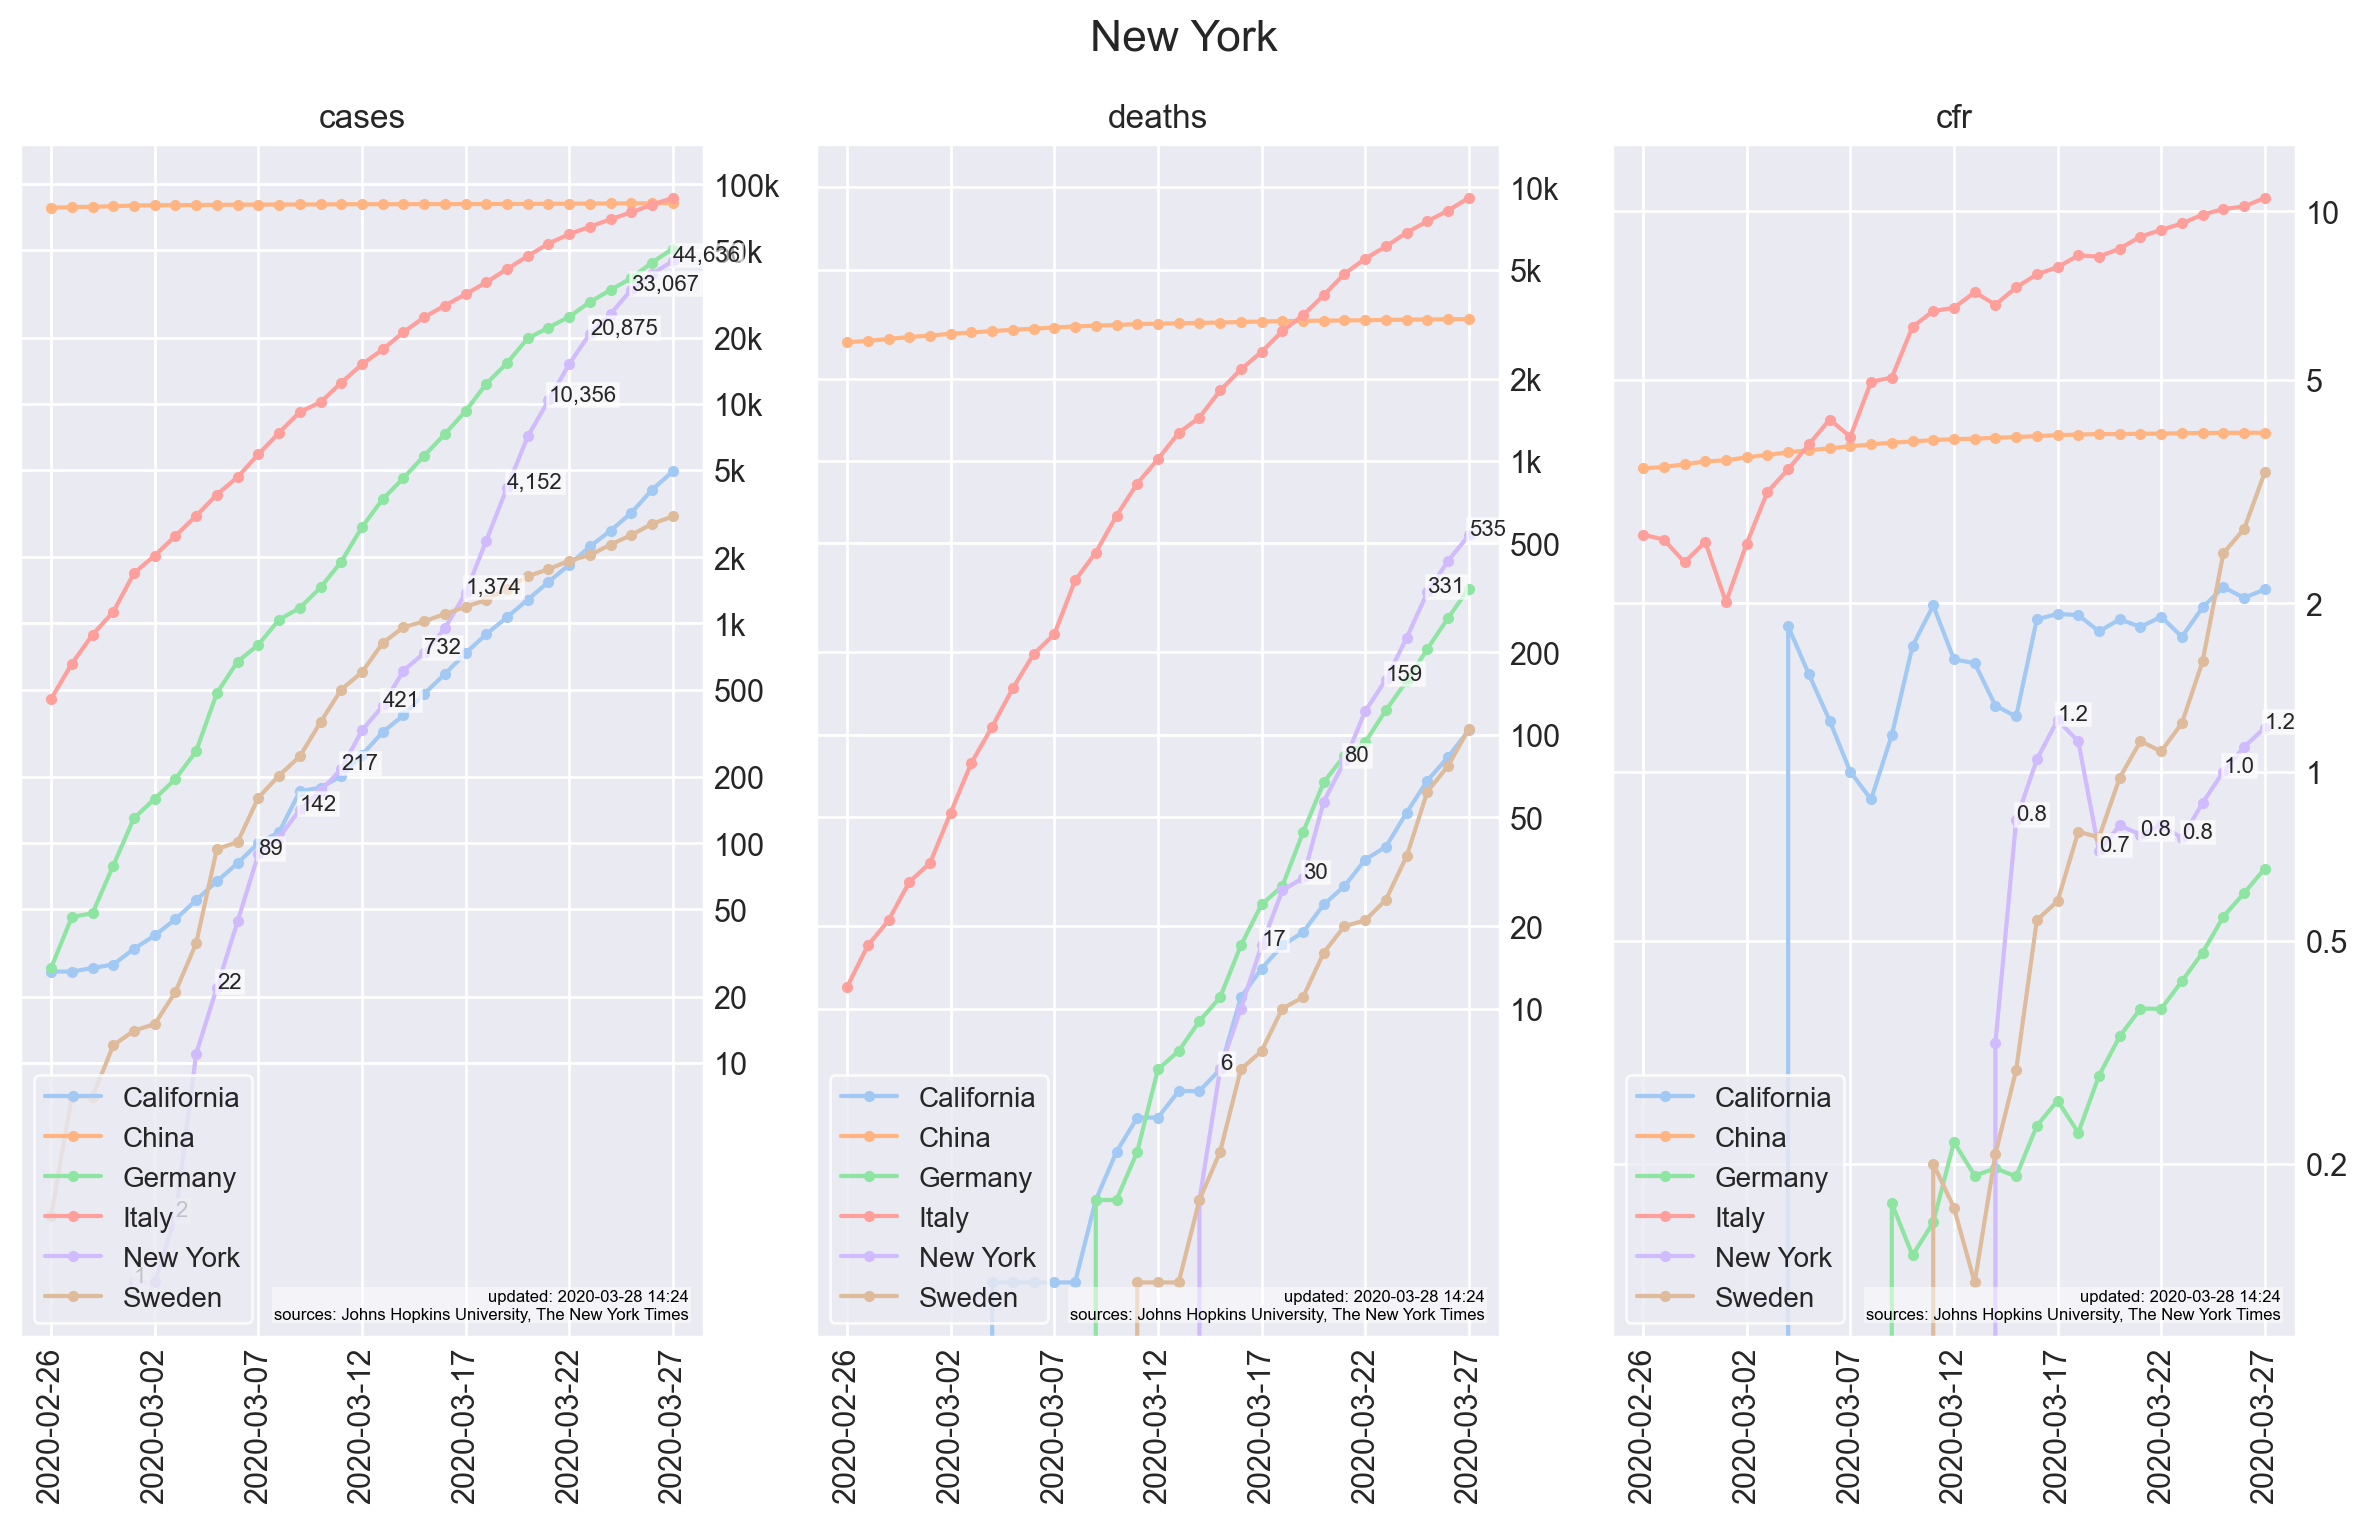

In [13]:
def get_timeseries(df, index, series, country=None, state=None, rollup_states=True):
    df = df.copy()

    if isinstance(country, str):
        country = [country]
    if isinstance(state, str):
        state = [state]

    df_country = df.loc[df['country'].isin(country)] if country else pd.DataFrame()

    if country and rollup_states:
        df_country = (
            rollup(df_country, 'country')
            .assign(state=lambda x: x['country'])
            .pipe(with_cfr)
            .pipe(with_diffs)
            .pipe(with_pct_change)
        )

    df_state = df.loc[df['state'].isin(state)] if state else pd.DataFrame()
    df = pd.concat([df_country, df_state], sort=True)

    df['region'] = df['state'].fillna(df['country'])#.str.lower()
    df = df.pivot(index=index, columns='region', values=series)
    return df


def plot(countries, states, plots, highlight='Italy', dpi=100):

    days = 31
    from_date = (dt.datetime.now() - dt.timedelta(days=days)).strftime("%Y-%m-%d")
    
    cols = len(plots)
    fig, axs = plt.subplots(1, cols, figsize=(cols * 4, 8), dpi=dpi, facecolor='white')
    
    for i, t in enumerate(plots.items()):
        series, df = t
        ax = axs[i] if cols > 1 else axs

        ts = get_timeseries(
            df,
            index='day',
            series=series,
            country=countries,
            state=states,
        )[from_date:]

        ax = ts.plot(title=series, legend=True, marker='.', ax=ax)
        
        # y-axis
        ax.set_yscale('log', basey=10)
        configure_yaxis(ax)
        ax.yaxis.tick_right()
        ax.tick_params(axis='both', which='both',length=0)

        # x-axis
        ax.xaxis.label.set_visible(False)
        ax.set_xticks(range(0, days, 5))
        ax.set_xticklabels(ts.index.values[::5])
        plt.setp(ax.get_xticklabels(), rotation=90)
        
        # data labels
        values = ts[highlight].values
        for i, v in enumerate(values):
            # plot when i has same parity as number of elements
            # e.g. for 20 values, want to plot odd numbered values
            # to ensure i=19 (last element) is annotated
            if ((len(values) % 2) == ((i + 1) % 2)) & (v > 0):
                frmt = f'{v:,.1f}' if series in ['cfr'] else f'{v:,.0f}'
                bbox = dict(pad=0.5, facecolor='white', alpha=0.6)
                ax.text(i, v, frmt, ha='left', fontsize=8, bbox=bbox)

        # info text box
        props = dict(color='black', fontsize=6, multialignment='right')
        box = AnchoredText(infotext(), loc=4, frameon=True, pad=0.1,
                           borderpad=0.8, prop=props)
        plt.setp(box.patch, facecolor='white', alpha=0.5, linewidth=0)
        ax.add_artist(box)
        
        # legend
        plt.sca(ax)
        leg = plt.legend(loc=3, prop={'size':10})
        leg.get_frame().set_edgecolor('white')
        leg.get_frame().set_linewidth(1.0)

    if cols > 1:
        fig.suptitle(highlight, fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])


eu5 = ['Italy', 'United Kingdom', 'Germany', 'Spain', 'France']
nordics = ['Sweden', 'Denmark', 'Norway', 'Finland']
asia = ['China', 'Korea, South', 'Singapore', 'Japan']
us = ['California', 'New York', 'Washington', 'New Jersey', 'Illinois']

# works best when picking 4-8 countries/states
df = CATALOG['df.derived.state']

plot(
    countries=eu5[:3] + nordics[:1] + asia[:2],
    states=us[:2],
    plots={
        'cases': df,
        'deaths': df,
        'cfr': df,
    },
    **dict(highlight='New York', dpi=200),
)